## Tutorial notebook to explain the Pauli noise tomography for a two-qubit example with a custom noise model 

The code is build on the recent version (see below) of qiskit at the time. 

In [22]:
import qiskit 
qiskit.__version__

'1.3.1'

In [23]:
#Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.circuit import QuantumRegister
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
#from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
#from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import Aer, AerSimulator,QasmSimulator
from random import random
from qiskit.transpiler import CouplingMap
#python imports
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [24]:
inst_map = [0,1,2,3]
n = len(inst_map)

layer = QuantumCircuit(2)

layer.cx(0,1)

layer.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

Here we define an Generic backend in qiskit with our desired coupling. For a two-qubit example: it is simply a bidirected coupling as defined below. 

In [25]:
coupling_list = [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_list)
connectivity = backend.coupling_map.graph.subgraph(inst_map)

As an example to explain the 9 measurement basis: we consider the following coupling of the qubit on the backend. Here, the 0th qubit has no predecessor and 1,2 qubits each has only one predecessor, where as the 3 qubit has two predecessor as it coupled to both 1 and 2 qubits. Please note that we need only the predecessors tp determine these basis and not the all coupling. For example: qubit 1 is connected to both 2 and 3 but both are successors.  

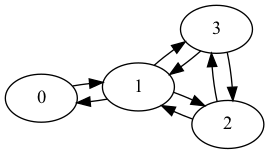

In [26]:
qiskit.transpiler.CouplingMap(couplinglist=coupling_list).draw()


Now, we take the 9 measurement basis needed to determine the sparse pauli lindblad model as described in IBM's paper. 

Let's first provide an explanation of why one needs only 9 measurement basis to determine the Pauli Noise model 
 

In [27]:
NUM_BASES = 9
def meas_bases():
    bases = [['I']*n for i in range(NUM_BASES)]

    for vertex in range(n):

        children = connectivity.neighbors(vertex)
        predecessors = [c for c in children if c < vertex]

        match len(predecessors):
            #trivial if no predecessors
            case 0:            
                cycp = cycle("XYZ")
                
                for i,_ in enumerate(bases):
                    bases[i][vertex] = next(cycp)

            #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
            case 1:
                pred, = predecessors
                #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                _,bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))
                cycp = cycle("XYZ")

                for i,_ in enumerate(bases):
                    bases[i][vertex] = next(cycp)

            case 2:
                pred0,pred1 = sorted(predecessors)
                #store permutation of indices so that first predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                _,bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))
                #ordering of the vertex with two predecessor has X,Y,Z,Z,X,Y,Y,Z,X
                order =  "XYZZXYYZX"
                for i,_ in enumerate(bases):             
                    bases[i][vertex] = order[i]
                    
            case _: #processor needs to have connectivity so that there are <= 2 predecessors
                raise Exception("Three or more predecessors encountered")
    # the pauli basis in 0,1,2,3 indices are rearranged according the qiskit 3,2,1,0 indices notation.
    bases = [Pauli("".join(string[::-1])) for string in bases]

    return bases

In [28]:
bases = meas_bases()
bases

[Pauli('XXXX'),
 Pauli('YYXY'),
 Pauli('ZZXZ'),
 Pauli('ZXYX'),
 Pauli('XYYY'),
 Pauli('YZYZ'),
 Pauli('YXZX'),
 Pauli('ZYZY'),
 Pauli('XZZZ')]


For just two qubits the 9 basis will simply be:

`'XX', 'YY', 'ZZ', 'XX', 'YY', 'ZZ', 'XX', 'YY', 'ZZ'`

The bases for more qubits can also be built using the above 9 basis and are built for 4 qubit system as following:

`'XIII', 'YIII','ZIII','XIII','YIII','ZIII','XIII','YIII','ZIII'`
Now the qubit 1 is connected to qubit 0 so we fill up first qubit index with all permutations of `'XYZ'` similar to a simple 2 qubit system but we first rearrange the list to have `'XIII'` terms first and then  `'YIII'` and followed by  `'ZIII'` to give 

`'XIII', 'XIII','XIII','YIII','YIII','YIII','ZIII','ZIII','ZIII'` $\longrightarrow$  `'XXII', 'XYII','XZII','YXII','YYII','YZII','ZXII','ZYII','ZZII'`

Now for the second qubit which has only one connected predecessor i.e. qubit 1, we repeat same logic by first rearranging the basis above in same manner, i.e., `-X--'`then `-Y--'` and then `-Z--'` and then complete filling the index 2 of the bases as follows:

 `'XXII', 'YXII','ZXII', 'XYII','YYII','ZYII','XZII','YZII','ZZII'`  $\longrightarrow$   `'XXXI', 'YXYI','ZXZI', 'XYXI','YYYI','ZYZI','XZXI','YZYI','ZZZI'` 

Now the third qubit has two connected predecessors, i.e., qubit 1 and 2. Here the logic changes to find all the 9 pairs of basis needed to determine each connected pair, for example: it is `(1,3)` and`(2,3)` in our example.

First sort the list of basis based on the predecessor qubit 1 and then fill the basis of qubit 3 by cycle permutting 'XYZ' to get pauli arrangement for all total 9 basis to be  `['XYZ', 'ZXY','YZX']` defined in the code in  combined string as `order = 'XYZZXYYZX'`. In this way we obtain all possible overall 9 basis by considering all 9 of length for each connected pair. 
 Following the same procedure, we get 

`'XXXI', 'YXYI','ZXZI', 'XYXI','YYYI','ZYZI','XZXI','YZYI','ZZZI'`  $\longrightarrow$  `'XXXX', 'YXYY', 'ZXZZ', 'XYXZ', 'YYYX', 'ZYZY', 'XZXY', 'YZYZ', 'ZZZX'`
  
One can assure that by following this we did include all the 9 pair basis for each connected pair of qubit 3.
 

## Move back to only two qubits example

In [29]:
inst_map = [0,1]
n = len(inst_map)
layer = QuantumCircuit(2)
layer.cx(0,1)
print(layer.draw())

coupling_list = [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_list)
connectivity = backend.coupling_map.graph.subgraph(inst_map)

bases = meas_bases()
bases

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘


[Pauli('XX'),
 Pauli('YX'),
 Pauli('ZX'),
 Pauli('XY'),
 Pauli('YY'),
 Pauli('ZY'),
 Pauli('XZ'),
 Pauli('YZ'),
 Pauli('ZZ')]

## Sparse model terms 

In [30]:
model_terms = set()
identity = Pauli("I"*n)    
#get all weight-two paulis on with suport on nieghboring qubits
for q1,q2 in connectivity.edge_list():
        for p1, p2 in pauli_basis(2, True):
            pauli = identity.copy()
            pauli[q1] = p1
            pauli[q2] = p2
            model_terms.add(pauli)

model_terms.remove(identity)
model_terms = (list(model_terms))
print("Model terms:", np.sort([m.to_label()[::-1] for m in model_terms]))
print(f"Number of model terms: {len(model_terms)}")

Model terms: ['IX' 'IY' 'IZ' 'XI' 'XX' 'XY' 'XZ' 'YI' 'YX' 'YY' 'YZ' 'ZI' 'ZX' 'ZY'
 'ZZ']
Number of model terms: 15


In [31]:
#remove the phase from a Pauli
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))

def conjugate(pauli):
    """It gives the Pdagger for noise twirling"""

    return nophase(pauli.evolve(layer))

In [32]:
def instance( 
    prep_basis : Pauli, 
    meas_basis : Pauli, 
    noise_repetitions : int, 
    transpiled=True):

    circ = QuantumCircuit(n) #storing the final circuit

    #get preparation ops from desired basis 
    def prep(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit) 
        elif basis.equiv(Pauli("Y")):
            qc.h(qubit)
            qc.s(qubit)

    #apply operators to a quantum circuit to measure in desired pauli basis
    def meas(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit)
        elif basis.equiv(Pauli("Y")):
            qc.sdg(qubit)
            qc.h(qubit)


    pauli_frame = Pauli("I"*n)

    #apply the prep operators to the circuit
    for q,b in enumerate(prep_basis):
        prep(b,q,circ)

    #apply repetitions of noise, including basis-change gates when needed
    for i in range(noise_repetitions):
        circ = circ.compose(layer)
        circ.barrier()


    for q,b in enumerate(meas_basis):        
        meas(b, q, circ)

    circ.measure_all()

    if transpiled:
        circ = transpile(circ, backend, initial_layout=inst_map, optimization_level = 1)

    circ.metadata = {
        "prep_basis":prep_basis,
            "meas_basis":meas_basis, 
            "depth":noise_repetitions
            }

    return circ 

example instance circuit

In [33]:
instance(Pauli("ZX"), Pauli("XI"),1,transpiled=False).draw()


┌───┐      ░       ░ ┌─┐   
   q_0: ┤ H ├──■───░───────░─┤M├───
        └───┘┌─┴─┐ ░ ┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░─┤ H ├─░──╫─┤M├
             └───┘ ░ └───┘ ░  ║ └╥┘
meas: 2/══════════════════════╩══╩═
                              0  1

In [34]:
def get_expectation(pauli = Pauli('II'), counts ={}):
        estimator = 0
        counts = counts
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            k = [i for i in key]            
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, k)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())

[Pauli('XI'), Pauli('XZ'), Pauli('ZX'), Pauli('YZ')] [0.019094365474415353, 0.006376725643485542, 0.012385877177298525, 0.011237276619718455]


Text(0, 0.5, '(1-f)')

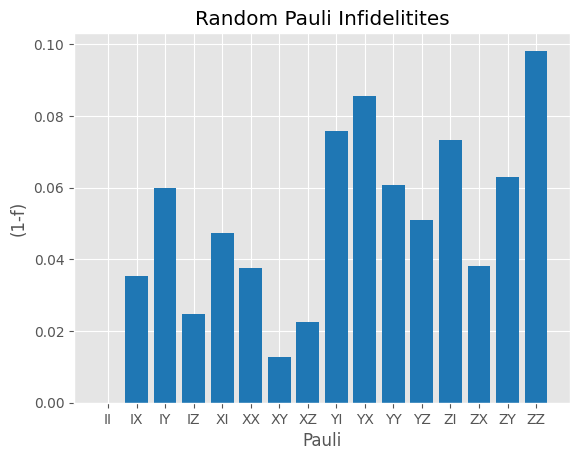

In [35]:
num = 4  #number of errors
import random
# for testing and reproducibility a random seed is taken 
random.seed(1)

errorops = random.sample(list(pauli_basis(2, True)), num) #choose random pauli errors
errorprobs = [random.random()*.1/num for op in errorops] #assign random probabilities
# these will be reproduced by learning the noise model later
print(errorops, errorprobs)
#create normalized error model

twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1- sum(errorprobs))])

#noise model for the AER simulators--custom model:--adding the list of the two qubit erros generated to the list of these gates ['cx','cz'] 
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

pauli_list = [pauli.to_label() for pauli in pauli_basis(2,  True)]
real_errors_sort = {}
# Pauli transfer matrices: basis of the matrix are in lexicographic order order. 
# Therefore, in order to read the elements of matrix, the pauli list has to be sorted
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data

for i,pauli in enumerate(sorted(pauli_list)):
    real_errors_sort[Pauli(pauli)] = transfer_matrix[i][i]
    plt.bar(pauli, (1-transfer_matrix[i][i]).real, color="tab:blue")


plt.title("Random Pauli Infidelitites")
plt.xlabel("Pauli")
plt.ylabel("(1-f)")

In [36]:
# QASM simulator is considered, we will add the custom noise model to it for simulations
sim = QasmSimulator()

## Just to explain the maths: we will considered a simple noise-model with only one error

In [37]:
num = 1  #number of errors

errorops = [Pauli("XX")] 
errorprobs = [0.02] 
print(errorops, errorprobs)

twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1- sum(errorprobs))])
#print(twoqubit_error)

#noise model for the AER simulators--custom model:--adding the list of the two qubit erros generated to the list of these gates ['cx','cz'] 
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

[Pauli('XX')] [0.02]


Text(0, 0.5, '(1-f)')

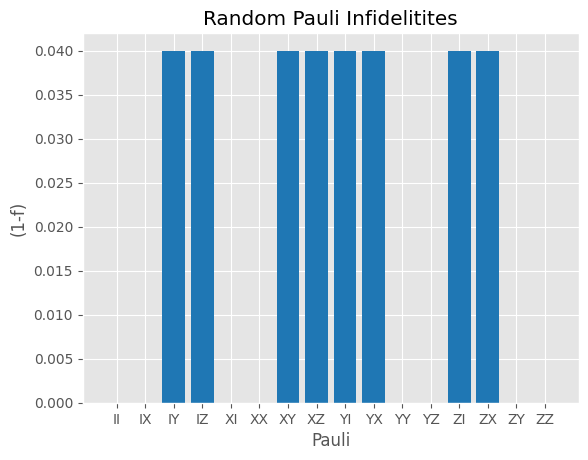

In [38]:
pauli_list = [pauli.to_label() for pauli in pauli_basis(2,  True) ]
real_errors_sort = {}
# Pauli transfer matrices 
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data

for i,pauli in enumerate(sorted(pauli_list)):
    real_errors_sort[Pauli(pauli)] = transfer_matrix[i][i]
    plt.bar(pauli, (1-transfer_matrix[i][i]).real, color="tab:blue")


# print(real_errors_sort)
plt.title("Random Pauli Infidelitites")
plt.xlabel("Pauli")
plt.ylabel("(1-f)")

For a simple case of $n=2$ and for the case of Pauli $\mathrm{IY}$ 
\begin{align}
\Lambda(P_a) &= \sum_i c_i P_i^\dagger (P_a) P_i  \\
\Lambda(\mathrm{IY}) &= 0.02 \times\mathrm{XX} (\mathrm{IY}) \mathrm{XX} + 0.98 \times\mathrm{IY}  \\
\Lambda(\mathrm{IY}) &= -0.02\times\mathrm{IY} + 0.98 \times\mathrm{IY} = 0.96 \times \mathrm{IY}  \\
\end{align}
and for say $\mathrm{ZZ} $

\begin{align}
\Lambda(\mathrm{ZZ}) &= 0.02 \times\mathrm{XX} (\mathrm{ZZ}) \mathrm{XX} + 0.98 \times\mathrm{ZZ}  \\
\Lambda(\mathrm{ZZ}) &= \mathrm{ZZ}  \\
\end{align}


and now the Pauli transfer matrix (PTM) can be build for as follows:

\begin{align}
\mathrm{PTM}(a,a) &= \frac{1}{2^2} \mathrm{Tr}\left[ P^\dagger_a \Lambda(P_a) \right] \\
\mathrm{PTM}(\mathrm{IY},\mathrm{IY}) &= \frac{1}{2^2} \mathrm{Tr}\left[ \mathrm{IY} (0.96 \times \mathrm{IY}) \right] = 0.96 \\
\mathrm{PTM}(\mathrm{IY},\mathrm{IY}) &= f_{\mathrm{IY}} = 0.96
\end{align}
Similarly,

\begin{align}
\mathrm{PTM}(\mathrm{ZZ},\mathrm{ZZ}) &= f_{\mathrm{ZZ}} = 1 
\end{align}

and for say $\mathrm{ZY} $

\begin{align}
\Lambda(\mathrm{ZY}) &= 0.02 \times\mathrm{XX} (\mathrm{ZY}) \mathrm{XX} + 0.98 \times\mathrm{ZY}  \\
\Lambda(\mathrm{ZY}) &= - 0.02 \times \mathrm{ZY}+ 0.98 \times\mathrm{ZY} =  0.96 \times\mathrm{ZY}  \\
\end{align}

and for say $\mathrm{XX} $

\begin{align}
\Lambda(\mathrm{XX}) &= 0.02 \times\mathrm{XX} (\mathrm{XX}) \mathrm{XX} + 0.98 \times\mathrm{XX}  \\
\Lambda(\mathrm{XX}) &= \mathrm{XX}  \\
\end{align}

### For check, we compute the fidelities of all the model terms using only single measurements 

In [39]:
SINGLE = 1
shots = 10000
for term in model_terms:
    print(f"For the model term: {term} with its clifford conjugate: {conjugate(term)}")
    circ = instance(prep_basis=conjugate(term), meas_basis=term,noise_repetitions= SINGLE,transpiled=False)
    #print(circ)
    result_single_counts = sim.run(circ,noise_model=noise_model, shots = shots).result().get_counts()
    print(f"measured error of {term} =", get_expectation(pauli = term, counts = result_single_counts), "and real error = ", real_errors_sort[term], "\n")

For the model term: ZI with its clifford conjugate: ZZ
measured error of ZI = 0.961 and real error =  (0.96+0j) 

For the model term: ZY with its clifford conjugate: YX
measured error of ZY = 1.0 and real error =  (1+0j) 

For the model term: YY with its clifford conjugate: ZX
measured error of YY = -1.0 and real error =  (1+0j) 

For the model term: YZ with its clifford conjugate: YI
measured error of YZ = 1.0 and real error =  (1+0j) 

For the model term: YX with its clifford conjugate: ZY
measured error of YX = 0.9588 and real error =  (0.96+0j) 

For the model term: XX with its clifford conjugate: IX
measured error of XX = 1.0 and real error =  (1+0j) 

For the model term: IY with its clifford conjugate: XY
measured error of IY = 0.964 and real error =  (0.96+0j) 

For the model term: XI with its clifford conjugate: XI
measured error of XI = 1.0 and real error =  (1+0j) 

For the model term: IZ with its clifford conjugate: IZ
measured error of IZ = 0.9582 and real error =  (0.96+0j

To build circuits for both cycle-bencharmarking and pair-breaking measurements, i.e., single measurements

In [40]:
def get_expectation(pauli, **metadata):
        estimator = 0
        counts = metadata['counts']
        #rostring = metadata['rostring']
        #compute locations of non-idetity terms (reversed indexing)
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            k = [i for i in key]            
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, k)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())
def weight(pauli):
    return len([p for p in pauli if not p==Pauli("I")])

#return True if Paulis differ by "I"s only
def disjoint(pauli1, pauli2):
    return all([p1==p2 or (p1 == Pauli("I") or p2 == Pauli("I")) for p1,p2 in zip(pauli1, pauli2)])

#return True if pauli requires a degeracy lifting measurement based on the conditions described above
def is_single(pauli):
    pair = conjugate(pauli)
    return (pauli in model_terms and pair in model_terms) and pauli != pair

#find disjoint operators that can be measured simultaneously to find six bases
pairs = set([frozenset([p,conjugate(p)]) for p in model_terms if is_single(p)])
#print(pairs)
single_bases = []
for p1,p2 in pairs:
    
    for i,pauli in enumerate(single_bases):
        if disjoint(pauli, p1) and disjoint(pauli, p2):
            single_bases[i] = nophase(pauli.compose(p2))
            break
    else:
        if weight(p1)<=weight(p2):
            single_bases.append(p2)
        else:
            single_bases.append(p1)

    #print(single_bases)

print("bases for singles: ",single_bases)
print("double bases: ", bases)

bases for singles:  [Pauli('ZX'), Pauli('YX'), Pauli('XX'), Pauli('YZ'), Pauli('ZZ'), Pauli('XY')]
double bases:  [Pauli('XX'), Pauli('YX'), Pauli('ZX'), Pauli('XY'), Pauli('YY'), Pauli('ZY'), Pauli('XZ'), Pauli('YZ'), Pauli('ZZ')]


In [41]:
SINGLE = 1
circuits = []
depths = [2,4,8,16,32,64]
samples = [100]*len(depths)
print(samples)
single_samples = 250
total = len(bases)*sum(samples)+len(single_bases)*single_samples

j=0
for basis, (d,s) in product(bases, zip(depths,samples)):
    for i in range(s):
        circ = instance(basis, basis, d,transpiled=True)
        circ.metadata["type"] = "double"
        circuits.append(circ)

        j+=1
        print(j,"/",total, end='\r')

for basis, s in product(single_bases, range(single_samples)):
    circ = instance(conjugate(basis),basis,SINGLE,transpiled=True)
    circ.metadata["type"] = "single"
    circuits.append(circ)

    j+=1
    print(j,"/",total, end='\r')

print(len(circuits))

[100, 100, 100, 100, 100, 100]
6900 / 6900


In [42]:
results = sim.run(circuits, shots=1000, noise_model = noise_model).result().get_counts()

In [43]:
#Shows whether two pauli operators can be measured simultaneously
def simultaneous(pauli1, pauli2):
    return all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(pauli1, pauli2)])

#Gives a list of all terms in the model that can be measured simultaneously with pauli
def sim_meas(pauli):
    return [term for term in model_terms if simultaneous(pauli, term)]

#Gives a list of all terms, in the sparse model or not, that can be measured simultaneously
#This is used to overdeteremine the model, but since it grows as 2^n, this method can always be
#replaced with sim_meas
def all_sim_meas(pauli):
    return [Pauli("".join(p)) for p in product(*zip(pauli.to_label(), "I"*n))]
#all_sim_meas = sim_meas


In [44]:
#Sort into single and double measurements
for res,circ in zip(results, circuits):
    circ.metadata["counts"] = res

singles = []
doubles = []
for circ in circuits:
    datum = circ.metadata
    type = datum["type"]
    datum.pop("type")
    if type == "single":
        singles.append(datum)
    elif type == "double":
        doubles.append(datum)

In [45]:
#reorder by measurement basis
basis_dict = {}
#improve execution time by storing runs of all_sim_meas for each basis
sim_measurements = {}
for datum in doubles:
    #print(datum)
    #get run data
    basis = datum['prep_basis']
    depth = datum['depth']
    #find simultaneous measurements
    if not basis in sim_measurements:
        sim_measurements[basis] = all_sim_meas(basis)
    #aggregate expectation value data for each simultaneous measurement
    for pauli in sim_measurements[basis]:
        expectation = get_expectation(pauli, **datum)
        #set up dictionary
        if not pauli in basis_dict:
            basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
        #add expectation value to result at depth
        basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
        basis_dict[pauli]["total"][depths.index(depth)] += 1

In [46]:
expfit = lambda x,a,b : a*np.exp(-x*b)
#for each of the simultaneous measurements
for key in basis_dict.keys():
    for i,d in enumerate(depths):
        #divide by total
        basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
    #try finding exponential fit, default to ideal if no fit found
    try:
        popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
    except:
        popt = 1,0

    #store fidelity and SPAM coefficients
    basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
    basis_dict[key]["SPAM"] = popt[0]

    #record whether measurement appears as a pair or as a single fidelity
    if key != conjugate(key):
        basis_dict[key]["type"] = "pair"
    else:
        basis_dict[key]["type"] = "single"

/var/folders/5p/92y041nj2xxcnv4mzy0r4z5m0000gn/T/ipykernel_76268/4168809998.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])


In [47]:
singles_dict = {} #store results of single measurements
sim_measurements = {}
for datum in singles:
    meas_basis = datum['meas_basis']
    prep_basis = datum['prep_basis']
    #find terms that can be measured simultaneously
    if not meas_basis in sim_measurements:
        sim_measurements[meas_basis] = []
        for term in model_terms:
            if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term)) and is_single(term):
                sim_measurements[meas_basis].append(term)
    #aggregate data together
    for meas in sim_measurements[meas_basis]:
        if meas not in singles_dict:
            singles_dict[meas] = 0
        expectation = get_expectation(meas, **datum)
        #the measurement basis SPAM coefficients are closer because the readout noise, combined
        #with the noise from the last layer, is greater than the state preparation noise
        fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
        singles_dict[meas] += fidelity/single_samples

#add singles data to basis_dict
for key in singles_dict.keys():
    basis_dict[key]['fidelity'] = singles_dict[key]
    basis_dict[key]['type'] = "single"

In [48]:
fidelities = []
fidelities_calculated = []
for p in model_terms:
    fid = basis_dict[p]['fidelity']
    
    if(basis_dict[p]['type'] == 'pair'):
        
        pair = conjugate(p)
        fid = fid**2/basis_dict[pair]['fidelity']
        
    fidelities.append(fid)
    fidelities_calculated.append(real_errors_sort[p])

/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


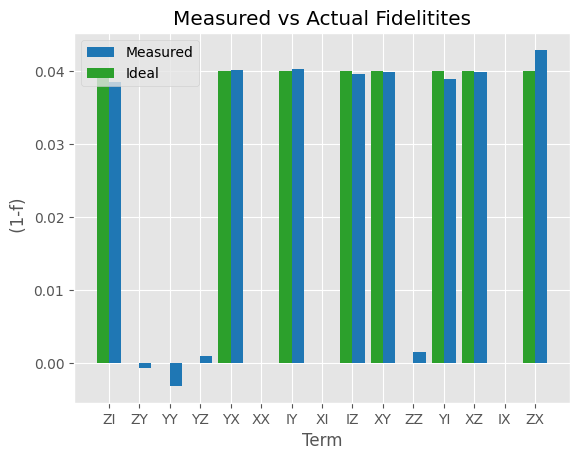

In [49]:
#graph a subset of the measured expectation values and plot fits
def graph(*paulis):
    colcy = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:olive"])
    for p in paulis:
        c = next(colcy)
        data = basis_dict[p]['expectation']
        popt, pcov = curve_fit(expfit, depths, data, p0=[.9,.01])
        xrange = np.linspace(0,np.max(depths))
        plt.plot(xrange, [expfit(x, *popt) for x in xrange], color=c)
        plt.plot(depths, data, color = c, marker="o", linestyle = 'None')
    plt.title("Expectation vs Depth")
    plt.xlabel("Depth")
    plt.ylabel("Fidelity")

#display the measured fidelities plotted against the ideal fidelitites
def display(*paulis):
    ax = np.arange(len(paulis))
    fidelities = []
    fidelities_calculated = []
    for p in paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = conjugate(p)
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors_sort[p])
    plt.bar(ax+.2, [(1-f) for f in fidelities], .4,color='tab:blue')
    plt.bar(ax-.2, [(1-f) for f in fidelities_calculated],.4, color='tab:green')
    plt.xticks(ax, paulis)
    plt.title("Measured vs Actual Fidelitites")
    plt.xlabel("Term")
    plt.ylabel(" (1-f)")
    plt.legend(["Measured", "Ideal"])
display(*model_terms)

In [81]:
f1 = []
f2 = []
fidelities = []
for key in model_terms:
    f1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    
    if basis_dict[key]["type"] == "pair":
        pair = conjugate(key)
        f2.append(pair)
    else:
        f2.append(key)

print("This is B1 list needed to build the M1 matrix:",([f.to_label() for f in f1]))
print("This is B2 list needed to build the M2 matrix:",([f.to_label() for f in f2]))
B1B2= []
for i,j in zip(f1,f2):
    if i.to_label()==j.to_label():
        B1B2.append((i.to_label(),j.to_label()))
    #if i==j:

print(B1B2)

This is B1 list needed to build the M1 matrix: ['ZI', 'ZY', 'YY', 'YZ', 'YX', 'XX', 'IY', 'XI', 'IZ', 'XY', 'ZZ', 'YI', 'XZ', 'IX', 'ZX']
This is B2 list needed to build the M2 matrix: ['ZZ', 'YX', 'ZX', 'YZ', 'YX', 'XX', 'XY', 'XI', 'IZ', 'XY', 'ZZ', 'YZ', 'XZ', 'XX', 'ZX']
[('YZ', 'YZ'), ('YX', 'YX'), ('XX', 'XX'), ('XI', 'XI'), ('IZ', 'IZ'), ('XY', 'XY'), ('ZZ', 'ZZ'), ('XZ', 'XZ'), ('ZX', 'ZX')]


In [82]:
sprod = lambda a,b: int(a.anticommutes(b))
M1 = [[sprod(a,b) for a in model_terms] for b in f1]
M2 = [[sprod(a,b) for a in model_terms] for b in f2]
# The rank of the M matrix has to be maximum, i.e., equal to model terms to find unique solution
np.linalg.matrix_rank(np.add(M1,M2))

15

In [83]:
coeffs,rnorm = nnls(np.add(M1,M2), -np.log(fidelities))
real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors_sort[term] for term in f1]))

/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/scipy/optimize/_nnls.py:120: ComplexWarning: Casting complex values to real discards the imaginary part
  resid = Atb.copy().astype(np.float64)  # x=0. Skip (-AtA @ x) term
/opt/anaconda3/envs/Quantum/lib/python3.11/site-packages/scipy/optimize/_nnls.py:135: ComplexWarning: Casting complex values to real discards the imaginary part
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],


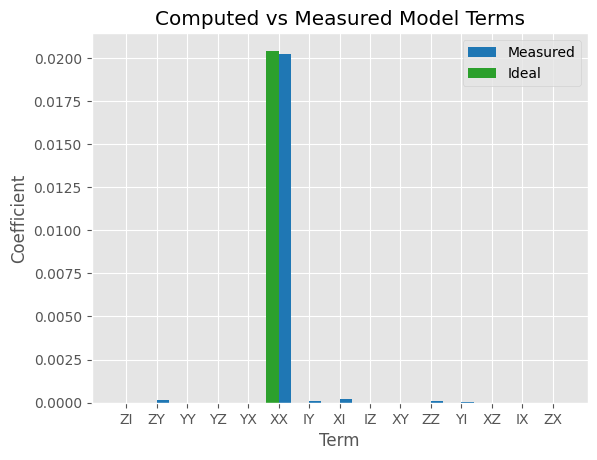

In [84]:
ax = np.arange(len(model_terms))
plt.bar(ax+.2, coeffs, .4, color='tab:blue')
plt.bar(ax-.2, real_coeffs, .4, color='tab:green')
plt.xticks(ax, model_terms);
plt.title("Computed vs Measured Model Terms")
plt.xlabel("Term")
plt.ylabel("Coefficient")
plt.legend(["Measured", "Ideal"])
